<a href="https://colab.research.google.com/github/acoiman/swb/blob/main/hot_spots_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Título: Algortimo para cálculo de focos de calor en cuencas
### Grupo 10
#### Descripción:
Algoritmo para cálculo de focos de calor en cuencas desagregadas a nivel 2 o 5 según se requiera.
##### Procedimiento general
+ Se selecciona colección FIRMS
+ Se selecciona las regiones de cuencas a nivel 2 o 5 definidas en el producto
+ Se define fecha de inicio y final de análisis.
+ Se filtra la colección FIRMS con las fecha definidas en el punto anterior
+ Se selecciona una subcolección de un mes de duración
+ Se reduce la subcolección a una escena tomando los valores máximos de los pixels
+ Se cuenta la cantidad de focos de calor por cuencas en la escena reducida
+ Se registra los valores computados
+ Se selecciona la siguiente subcolección de un mes de duración. Si se termina la cantidad de subcolecciones se procede al siguiente punto.
+ Se da formato a los datos para entregarlos al procesador de variables.

### Diagrama de flujo

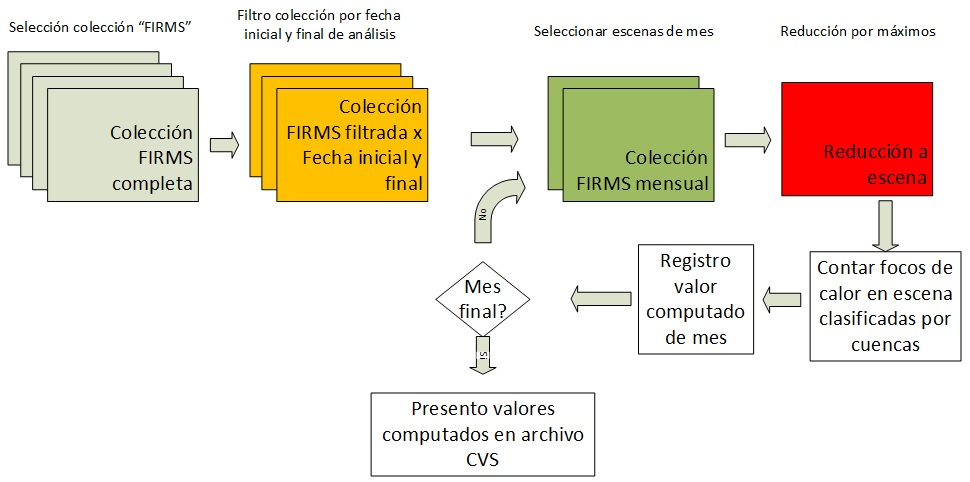

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=qdq92w36_TS6pG_mguVC1FHeVNfG7qTGU4GAWx5vg1A&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5NJV5-JL1t6uaazhKjeGqprFnHBbiW9-tT7RkcOfY9Zo3mjKjFXJQ

Successfully saved authorization token.


### Accedamos a los servicios de almacenamiento de Google Drive.

In [5]:
# Authenticate to Google Drive
# Mount Google Drive
from google.colab import drive # import drive from google colab

# default location for the drive
ROOT = "/content/drive" 
print(ROOT) # print content of ROOT (optional)

drive.mount(ROOT) # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


### Cambiémonos a nuestra carpeta de trabajo. Se debe crear una carpeta con el nombre Colab_Notebooks y dentro de esta una carpeta con el nombre Taller_GEE_Inc_2021, en caso contrario configure su ruta particular.

In [6]:
%cd "drive/MyDrive/Colab_Notebooks/Taller_GEE_Inc_2021"

/content/drive/MyDrive/Colab_Notebooks/Taller_GEE_Inc_2021


### Elección de tipo de cuenca mediante producto WWF HydroSHEDS Basins level 2 o 5

In [7]:
basin_id = [6020029280, 6020017370, 6020021870, 6020008320,  6020014330, 6020000010, 6020006540];
geometry = ee.Geometry.Polygon(
        [[[-72.38057697749733, 15.92409528792919],
          [-78.00557697749733, 4.526872170566439],
          [-86.97042072749733, -6.87761574728738],
          [-76.59932697749733, -29.568915186977126],
          [-77.01620465827378, -57.81857384216577],
          [-59.08651715827378, -57.15724624674272],
          [-45.37557965827378, -36.9105889495516],
          [-30.43417340827378, -7.7493629697489705],
          [-37.64120465827378, 2.948256110220539],
          [-54.69198590827378, 13.031053599052584]]]
)
basins_l5 = ( ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_5").filterBounds(geometry))
        
basins_l2 = ( ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_2")
         .filter(ee.Filter.inList('HYBAS_ID',basin_id))
)

# Elección de nivel de detalle de cuencas si se procesan cuencas nivel 5 asignas a variable basin = basins_l5
# si se procesan cuenca a nivel 2 asignar a variable basin = basins_l2
basins = basins_l2


In [8]:
# Función para filtrar colección FIRMS entre fechas requeridas
def compute_burned_area(start_date,end_date,basins):
    
    burned_area_collection = ( ee.ImageCollection("FIRMS") 
        .filterDate(start_date,end_date)
        .select('T21')
    )
    def filter_burned_area(img):
        return img.gt(0)
    burned_area_collection = burned_area_collection.map(filter_burned_area)
    burned_area_img = burned_area_collection.max()
    result = burned_area_img.reduceRegions(**{
        'collection' : basins,
        'reducer' : ee.Reducer.count(),
        'scale' : 1000
    })
    data = result.getInfo()
   
    return data 

# Función tomar datos calculados y juntarlos en 1 diccionario
def format_columns(result_data):
    result_values = {}
    for feature in result_data['features']:
        prop = feature['properties']
        result_values[prop['HYBAS_ID']] = prop['count']
    return result_values

In [9]:
# Importo módulos a utilizar para separar colecciones mensuales y medir tiempos de procesamiento
from dateutil import rrule
import datetime 
import time

# Defino fechas de interés
start_date = datetime.datetime(2001,2,1)
end_date  = datetime.datetime(2001,4,30)
start = '2001-01'
array = []
index = []
# Defino bucle para recorrer mensualmente el período de interés
for dt in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date): # Recorro el objeto iterable mediante dt mensualmente entre la fecha de inicio y de fin
    start_time = time.time()                                              # Guardo el momento en cual arrancó el procesamiento
    end = dt.strftime('%Y-%m')                                            # Paso a str  en formato YYYY-MM seleccionado
    data = compute_burned_area(start,end,basins)                          # Calculo el área quemada en ese período de tiempo
    values = format_columns(data)                                         # Pongo los datos generados en formato...
    total_time = time.time() - start_time
    print("time=%s"%(total_time))
    index.append(start)
    array.append(values)
    start = end

time=3.8671257495880127
time=3.7740020751953125
time=3.123865842819214


In [10]:
# Ordeno los datos de focos de calor utilizando módulo pandas

import pandas as pd
df = pd.DataFrame(array,index=index)
df.to_csv('partial_burned_area.csv')
df

,6020000010,6020006540,6020008320,6020014330,6020017370,6020021870,6020029280
2001-01,33158,6564,4045,9549,31115,292,247
2001-02,47460,10461,5188,6468,8159,430,258
2001-03,57333,7685,2540,8584,3297,1099,651


In [11]:
# Ordeno datos para entregar a compilador de datos "Superset"

columns = list(df.columns)
array = []
area = 1 #250 * 250 / 1000000 #km2
for c in columns: 
    subset = df[ [ c ] ] 
    subset.rename(columns={c : 'foco_calor'},inplace=True) 
    subset['basin_id'] = c
    subset['foco_calor'] = subset['foco_calor'] * area
    array.append(subset)
    
total = pd.concat(array)
total.to_csv('hot_spot.csv')
total

,foco_calor,basin_id
2001-01,33158,6020000010
2001-02,47460,6020000010
2001-03,57333,6020000010
2001-01,6564,6020006540
2001-02,10461,6020006540
2001-03,7685,6020006540
2001-01,4045,6020008320
2001-02,5188,6020008320
2001-03,2540,6020008320
2001-01,9549,6020014330
